# 7 - CLUSTERING DBSCAN

**AUTOR: Fabrizio Ramirez Cutimbo**

**OBJETIVO**

+ Aplicar la técnica de clustering DBSCAN a los dataset preprocesados.
+ Evaluar la mejor configuración de Clusters en relación al epsilon y número mínimo de elementos
+ Generar clusters con la mejor configuración posible
+ Visualizar los clusters generados.
---

In [1]:
import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import umap
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

c:\Users\fabrizio\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd_companias = pd.read_csv('Datasets Procesados/directorio_empresas_final_UMAP.csv', dtype={'RUC': 'object'})

In [3]:
print(pd_companias.shape)
pd_companias.sample(2)

(37884, 87)


,EXPEDIENTE,RUC,SITUACION_LEGAL,FECHA_CONSTITUCION,TIPO,PAIS,REGION,PROVINCIA,CANTON,CIUDAD,...,CIIU_NIVEL_1_N,REGION_COSTA,REGION_GALÁPAGOS,REGION_ORIENTE,REGION_SIERRA,SEGMENTO_ENCODED,Set4_UMAP1,Set4_UMAP2,Set4_REGION_UMAP1,Set4_REGION_UMAP2
22614,334734,1291789804001,ACTIVA,06/05/2022,SOCIEDAD POR ACCIONES SIMPLIFICADA,ECUADOR,COSTA,LOS RIOS,QUEVEDO,QUEVEDO,...,0.0,1.0,0.0,0.0,0.0,2,7.295590,8.595444,8.598900,5.738953
10057,151710,1791934849001,ACTIVA,11/05/2004,RESPONSABILIDAD LIMITADA,ECUADOR,SIERRA,PICHINCHA,QUITO,QUITO,...,0.0,0.0,0.0,0.0,1.0,2,18.062735,4.234417,14.740858,-4.429679


In [4]:
pd_companias.columns

Index(['EXPEDIENTE', 'RUC', 'SITUACION_LEGAL', 'FECHA_CONSTITUCION', 'TIPO',
       'PAIS', 'REGION', 'PROVINCIA', 'CANTON', 'CIUDAD', 'CIIU_NIVEL_1',
       'CIIU_NIVEL_1_DESC', 'CIIU_NIVEL_3', 'CIIU_NIVEL_3_DESC',
       'CIIU_NIVEL_4', 'CIIU_NIVEL_4_DESC', 'CIIU_NIVEL_6',
       'CIIU_NIVEL_6_DESC', 'ACTIVO_2022', 'ACTIVO_CORRIENTE_2022',
       'INVENTARIOS_2022', 'ACTIVOS_NO_CORRIENTES_2022', 'PASIVO_2022',
       'PASIVO_CORRIENTE_2022', 'PASIVO_NO_CORRIENTE_2022',
       'PATRIMONIO_NETO_2022', 'INGRESOS_ACTIVIDADES_ORDINARIAS_2022',
       'GANANCIA_BRUTA_2022', 'OTROS_INGRESOS_2022',
       'COSTO_VENTAS_PRODUCCION_2022', 'GASTOS_2022',
       'UTILIDAD_OPERATIVA_2022', 'GANACIA_PERDIDA_ANTES_IR_2022',
       'IMPUESTO_RENTA_2022', 'UTILIDAD_NETA_2022', 'ACTIVO_2023',
       'ACTIVO_CORRIENTE_2023', 'INVENTARIOS_2023',
       'ACTIVOS_NO_CORRIENTES_2023', 'PASIVO_2023', 'PASIVO_CORRIENTE_2023',
       'PASIVO_NO_CORRIENTE_2023', 'PATRIMONIO_NETO_2023',
       'INGRESOS_ACTIVID

**EPS EPSILON**: Distancia máxima que puede existir entre dos puntos para que sean consideras "Vecinos".
+ Valores pequeños pueden generar clusteres pequeños
+ Valores grandes pueden generar clusteres grandes

**min_samples** Número mínimo de puntos que un Grupo necesita para ser considerado un cluster.

**SILUETA**
Es una métrica que mide qué tan bien separados y cohesionados están los clústeres generados por un algoritmo de agrupamiento, como K-Means. Es útil para evaluar la calidad del agrupamiento y determinar si los datos se agrupan correctamente.
- 1: El punto está bien asignado a su clúster y es distante de otros clústeres.
- 0: El punto está en el límite entre dos clústeres, no claramente asignado.
- -1: El punto está mal asignado, ya que está más cerca de un clúster diferente.


### EVALUACIÓN PARÁMETROS

In [5]:
def evaluar_dbscan(dataset, columnas, eps_values, min_samples_values, metric='euclidean'):
    """
    Evalúa la silueta y el número de clústeres para diferentes combinaciones de parámetros de DBSCAN.

    Parámetros:
        dataset (DataFrame): El dataset que contiene las columnas a analizar.
        columnas (list): Lista de columnas sobre las cuales se aplica DBSCAN.
        eps_values (list): Lista de valores para el parámetro eps.
        min_samples_values (list): Lista de valores para el parámetro min_samples.
        metric (str): Métrica de distancia para DBSCAN (por defecto 'euclidean').
  
    Salida:
        dict: Contiene las mejores combinaciones de parámetros según la silueta y el número de clústeres.
        Genera una gráfica comparativa de Silueta y Número de Clústeres.
    """
    silhouette_scores = []
    num_clusters_list = []
    params = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            labels = dbscan.fit_predict(dataset[columnas])
            
            # Calcular número de clústeres (ignorar el ruido, etiquetado como -1)
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            
            # Calcular silueta solo si hay más de 1 clúster
            if num_clusters > 1:
                silhouette_avg = silhouette_score(dataset[columnas], labels)
            else:
                silhouette_avg = np.nan
            
            silhouette_scores.append(silhouette_avg)
            num_clusters_list.append(num_clusters)
            params.append((eps, min_samples))

    # Identificar las mejores combinaciones según la silueta y el número de clústeres
    top_silhouette = sorted(
        zip(params, silhouette_scores, num_clusters_list), 
        key=lambda x: x[1], 
        reverse=True
    )[:3]

    # Crear una gráfica para comparar las métricas
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(range(len(params)), silhouette_scores, 'b-', label="Silueta", marker='o')
    ax2.plot(range(len(params)), num_clusters_list, 'g-', label="Número de Clústeres")

    ax1.set_xlabel('Configuraciones de Parámetros')
    ax1.set_ylabel('Silueta', color='b')
    ax2.set_ylabel('Número de Clústeres', color='g')

    plt.title('Silueta y Número de Clústeres vs Configuraciones de Parámetros')
    plt.show()

    return {
        "mejores_silueta": top_silhouette
    }

In [ ]:
eps_values = [0.25, 0.5, 0.65, 0.75]
min_samples_values = [20, 50, 70, 100, 120]

resultados_dbscan = evaluar_dbscan(
    dataset=pd_companias,
    columnas=['Set4_UMAP1', 'Set4_UMAP2'],
    eps_values=eps_values,
    min_samples_values=min_samples_values
)


In [ ]:
print("Top 3 silueta:", resultados_dbscan['mejores_silueta'])

### Clusterización DBSCAN
Función Clusterización DBSCAN

In [6]:
def clusterizacion_algoritmo_dbscan(dataset, columnas, eps, min_samples, columna_salida, sufijo=''):
    """
    Aplica el modelo DBSACN a un DataFrame y agrega una columna con los clusters asignados.

    Parameters:
    dataset (pd.DataFrame): El DataFrame sobre el cual se aplicará KMeans.
    columnas (list): Lista de nombres de las columnas para realizar el clustering.
    n_clusters (int): Número de clusters a generar.
    random_state (int): Semilla para reproducibilidad.
    n_init (int): Número de inicializaciones para el algoritmo.
    sufijo (str): Sufijo que se agregará al nombre de la columna de clusters.

    Returns:
    pd.DataFrame: DataFrame con una nueva columna para los clusters asignados.
    """
    # Crear una copia del DataFrame para evitar problemas de vistas
    dataset = dataset.copy()

    # Crear el modelo DBSCAN
    model = DBSCAN(eps=eps, min_samples=min_samples)

    # Ajustar el modelo con las columnas seleccionadas
    model.fit(dataset[columnas])
    # model.fit_predict(dataset[columnas])

    # Agregar los clusters al DataFrame y añadir el sufijo si se proporciona
    if sufijo:
        dataset[columna_salida] = [f"{cluster}_{sufijo}" for cluster in model.labels_]
    else:
        dataset[columna_salida] = model.labels_

    return dataset


#### Clusterización Set 4

C:\Users\fabrizio\AppData\Local\Temp\ipykernel_17860\1536139476.py:11: UserWarning: 
The palette list has fewer values (12) than needed (61) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x="Set4_UMAP1", y="Set4_UMAP2", hue=pd_companias_UMAP_set_4_DBSCAN_clustered_clean_noise[column_cluster_dbscan_name],


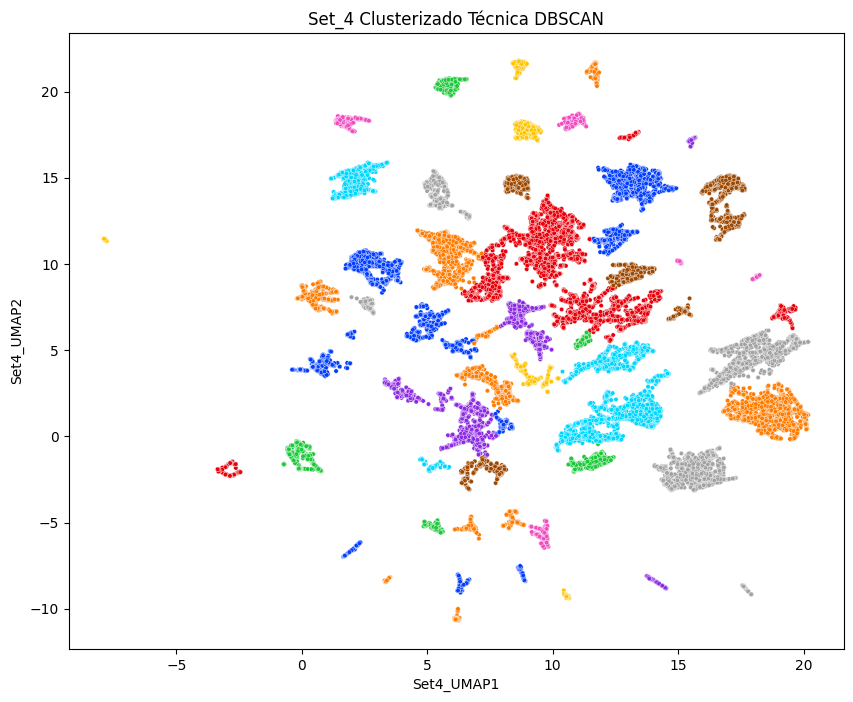

In [7]:
column_cluster_dbscan_name = 'CLUSTER_DBSCAN_SET_4'
pd_companias_UMAP_set_4_DBSCAN_clustered = clusterizacion_algoritmo_dbscan(dataset=pd_companias, columnas=['Set4_UMAP1', 'Set4_UMAP2'], 
                                                                     eps=0.5, min_samples=100, columna_salida=column_cluster_dbscan_name, sufijo='')

palette = sns.color_palette("bright", n_colors=12)

# Limpiar valores que no fueron asignados a ningun cluster solo para visualizar
pd_companias_UMAP_set_4_DBSCAN_clustered_clean_noise = pd_companias_UMAP_set_4_DBSCAN_clustered[pd_companias_UMAP_set_4_DBSCAN_clustered[column_cluster_dbscan_name]!=-1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x="Set4_UMAP1", y="Set4_UMAP2", hue=pd_companias_UMAP_set_4_DBSCAN_clustered_clean_noise[column_cluster_dbscan_name],
                palette=palette, 
                data=pd_companias_UMAP_set_4_DBSCAN_clustered_clean_noise,
                legend=False,  # Ocultar la leyenda
                s=10
)
plt.title('Set_4 Clusterizado Técnica DBSCAN')
plt.show()

In [8]:
print(pd_companias.shape)
pd_merged = pd_companias

pd_merged = pd.merge(pd_merged, pd_companias_UMAP_set_4_DBSCAN_clustered[['RUC',column_cluster_dbscan_name]], left_on='RUC', right_on='RUC', how='inner')
print(pd_merged.shape)

pd_merged.columns

(37884, 87)
(37884, 88)


Index(['EXPEDIENTE', 'RUC', 'SITUACION_LEGAL', 'FECHA_CONSTITUCION', 'TIPO',
       'PAIS', 'REGION', 'PROVINCIA', 'CANTON', 'CIUDAD', 'CIIU_NIVEL_1',
       'CIIU_NIVEL_1_DESC', 'CIIU_NIVEL_3', 'CIIU_NIVEL_3_DESC',
       'CIIU_NIVEL_4', 'CIIU_NIVEL_4_DESC', 'CIIU_NIVEL_6',
       'CIIU_NIVEL_6_DESC', 'ACTIVO_2022', 'ACTIVO_CORRIENTE_2022',
       'INVENTARIOS_2022', 'ACTIVOS_NO_CORRIENTES_2022', 'PASIVO_2022',
       'PASIVO_CORRIENTE_2022', 'PASIVO_NO_CORRIENTE_2022',
       'PATRIMONIO_NETO_2022', 'INGRESOS_ACTIVIDADES_ORDINARIAS_2022',
       'GANANCIA_BRUTA_2022', 'OTROS_INGRESOS_2022',
       'COSTO_VENTAS_PRODUCCION_2022', 'GASTOS_2022',
       'UTILIDAD_OPERATIVA_2022', 'GANACIA_PERDIDA_ANTES_IR_2022',
       'IMPUESTO_RENTA_2022', 'UTILIDAD_NETA_2022', 'ACTIVO_2023',
       'ACTIVO_CORRIENTE_2023', 'INVENTARIOS_2023',
       'ACTIVOS_NO_CORRIENTES_2023', 'PASIVO_2023', 'PASIVO_CORRIENTE_2023',
       'PASIVO_NO_CORRIENTE_2023', 'PATRIMONIO_NETO_2023',
       'INGRESOS_ACTIVID

## Generar Dataset con Cluster DBSCAN

In [9]:
pd_merged.to_csv('Datasets Procesados\\directorio_empresas_final_UMAP_DBSCAN.csv', index=False)

-----------